# Saliency methods for VGG inspired net - artificial + simple data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

import os 
import h5py

import keras
from keras.utils import Sequence
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.backend.tensorflow_backend import set_session

from sklearn.preprocessing import minmax_scale

from classification_models import Classifiers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Activation

import time 

import innvestigate
import deeplift
import pickle as pkl

Using TensorFlow backend.


In [2]:
plt.rcParams["font.size"] = "12"

In [3]:
data_dir = '/path/to/data'
result_dir = '/path/to/results'
weight_dir = os.path.join(result_dir, 'best_weights_trial_0.hdf5')

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "6"
set_session(tf.Session(config=config))

In [5]:
save_heatmaps = True
save_fig = True
heatmaps_precomputed = False 

## Load and preprocess data

In [6]:
holdout_h5 = h5py.File(os.path.join(data_dir, 'holdout_data.h5'), 'r')
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_holdout = np.array(X_holdout[:12000])
y_holdout = np.array(y_holdout[:12000])

In [7]:
train_h5 = h5py.File(os.path.join(data_dir, 'training_data.h5'), 'r')
X_train, y_train = train_h5['X'], train_h5['y']
X_train = np.array(X_train[:42000])
y_train = np.array(y_train[:42000])

In [8]:
def normalize_float(x, is_3d_mri=True):
    """ 
    Function that performs max-division normalization on a `numpy.ndarray` 
    matrix. 
    """
    if is_3d_mri:
        assert(len(x.shape) >= 4)
    for i in range(x.shape[0]):
        x[i] /= np.max(x[i])
    return x


class IntensityRescale:
    """
    Rescale image itensities between 0 and 1 for a single image.
    Arguments:
        masked: applies normalization only on non-zero voxels. Default
            is True.
        on_gpu: speed up computation by using GPU. Requires torch.Tensor
             instead of np.array. Default is False.
    """

    def __init__(self, masked=True, on_gpu=False):
        self.masked = masked
        self.on_gpu = on_gpu

    def __call__(self, image):
        if self.masked:
            image = self.zero_masked_transform(image)
        else:
            image = self.apply_transform(image)

        return image

    def apply_transform(self, image):
        if self.on_gpu:
            return normalize_float_torch(image)
        else:
            return normalize_float(image, is_3d_mri = False)

    def zero_masked_transform(self, image):
        """ Only apply transform where input is not zero. """
        img_mask = image == 0
        # do transform
        image = self.apply_transform(image)
        image[img_mask] = 0.
        return image

def sagittal_flip(batch):
    """ 
        Expects shape (None, X, Y, Z, C).
        Flips along the X axis (sagittal).
        
    """
    thresh = 0.5
    batch_augmented = np.zeros_like(batch)
    for idx in range(len(batch)):
        rand = np.random.uniform()
        if rand > thresh:
            batch_augmented[idx] = np.flip(batch[idx], axis=0)
        else:
            batch_augmented[idx] = batch[idx]
    return batch_augmented

def translate(batch):
    """ 
        Expects shape (None, X, Y, Z, C).
        Translates the X axis.
    """
    batch_augmented = np.zeros_like(batch)
    for idx in range(len(batch)):
        rand = np.random.randint(-2, 3)
        if rand < 0:
            batch_augmented[idx,-rand:] = batch[idx,:rand]
        elif rand > 0:
            batch_augmented[idx,:-rand] = batch[idx,rand:]
        else:
            batch_augmented[idx] = batch[idx]
    return batch_augmented

In [9]:
intensity = IntensityRescale(masked = False)

In [10]:
class DataLoader(Sequence):
    def __init__(self, X, y, transform = None, batch_size = 32, shuffle = True, mask = None):
        self.X = X
        self.y = y 
        self.transform = transform 
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mask = mask 
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size], 3)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None: 
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform: 
            image = transformation(image)
            
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
test_loader = DataLoader(X = X_holdout, y = y_holdout, batch_size = 1, shuffle = False, transform = [intensity])
train_loader = DataLoader(X = X_train, y = y_train, batch_size = 1, shuffle = False, transform = [intensity])

In [12]:
X_train_inn = [train_loader[i][0][0] for i in range(len(train_loader))]

In [13]:
with open(os.path.join(data_dir, 'ground_truth_maps_holdout.pkl'), 'rb') as f:
    ground_truth = pkl.load(f)

## Instantiate model

In [14]:
def SimpleModel(input_shape, drop_rate = None, weight_dcay = None):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='softmax'))
    return model

In [18]:
def get_heatmap_list(dataloader, model, weight_dir, interpretation_method = 'lrp.epsilon', num_heatmaps = 200, **kwargs):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    score_list = []    
    
    random_weights = model.get_weights()
    # Creating an analyzer
    model.load_weights(weight_dir)
    
    model_wo_softmax = innvestigate.utils.model_wo_softmax(model)
    
    gradient_analyzer = innvestigate.create_analyzer(interpretation_method, model_wo_softmax, **kwargs)

    
    if interpretation_method == 'pattern.net' or interpretation_method == 'pattern.attribution': 
        gradient_analyzer.fit(np.array(X_train_inn), verbose = True)
    
    for image_idx in range(num_heatmaps):        
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
    
        analysis = gradient_analyzer.analyze(image)
        heatmap_list.append(analysis)
            
        prob = model.predict_on_batch(image)[0]
        presm = model_wo_softmax.predict_on_batch(image)[0]
        y_hat = prob.argmax()
        
        score_list.append((prob, presm, y_hat))

    return heatmap_list, score_list

In [19]:
list_idx = np.random.choice(200, 8, replace = False)

[171  82 186   7  74 154 185  95]


In [20]:
methods_params = [('gradient', {}), ('deep_taylor', {}), ('lrp.z', {}), ('lrp.alpha_beta', {'alpha' : 2, 'beta' : 1}), ('deconvnet', {}), ('guided_backprop', {}), ('pattern.net', {'pattern_type' : 'relu'}), ('pattern.attribution', {'pattern_type' : 'relu'})]

In [ ]:
input_shape = X_train[0].shape

In [22]:
if heatmaps_precomputed is True: 
    with open(os.path.join(result_dir, 'heatmaps/simple_model_best_fold.pkl'), 'rb') as f:
        dict_all_heatmaps = pkl.load(f)
    with open(os.path.join(result_dir, 'heatmaps/prediction_scores.pkl'), 'rb') as f:
        dict_all_scores = pkl.load(f)
else:
    dict_all_heatmaps = {}
    dict_all_scores = {}
    for i, m in enumerate(methods_params): 
        model = SimpleModel(input_shape = (input_shape[0], input_shape[1], 1))
        method = m[0]
        print(method)
        params = m[1]
        heatmap_list, score_list = get_heatmap_list(test_loader, model = model, weight_dir = weight_dir, interpretation_method = method, **params)
        dict_all_heatmaps[method] = heatmap_list
        dict_all_scores[method] = score_list

gradient
deep_taylor
lrp.z
lrp.alpha_beta
deconvnet
guided_backprop
pattern.net
Epoch 1/1
1313/1313 [==============================] - 169s 129ms/step - loss: 10.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000 - broadcast_7_loss: 1.0000 - broadcast_8_loss: 1.0000 - broadcast_9_loss: 1.0000 - broadcast_10_loss: 1.0000
pattern.attribution
Epoch 1/1
1313/1313 [==============================] - 169s 129ms/step - loss: 10.0000 - broadcast_11_loss: 1.0000 - broadcast_12_loss: 1.0000 - broadcast_13_loss: 1.0000 - broadcast_14_loss: 1.0000 - broadcast_15_loss: 1.0000 - broadcast_16_loss: 1.0000 - broadcast_17_loss: 1.0000 - broadcast_18_loss: 1.0000 - broadcast_19_loss: 1.0000 - broadcast_20_loss: 1.0000


In [23]:
if save_heatmaps is True: 
    with open(os.path.join(result_dir, 'heatmaps/simple_model_best_fold.pkl'), 'wb') as f: 
        pkl.dump(dict_all_heatmaps, f)
    with open(os.path.join(result_dir, 'heatmaps/prediction_scores.pkl'), 'wb') as f: 
        pkl.dump(dict_all_scores, f)

In [24]:
# Normalization methods 
def explanation_to_heatmap(e):
    tmp = (e/np.max(np.abs(e))) * 127.5 + 127.5
    colormap = plt.cm.get_cmap("seismic")
    tmp = colormap(tmp.flatten().astype(np.int64))[: , :3]
    tmp = tmp.reshape((e.shape[0], e.shape[1], 3)) 
    return tmp

def explanation_to_projection(e):
    # To range [0, 1]
    return (np.abs(e)/np.max(np.abs(e)))

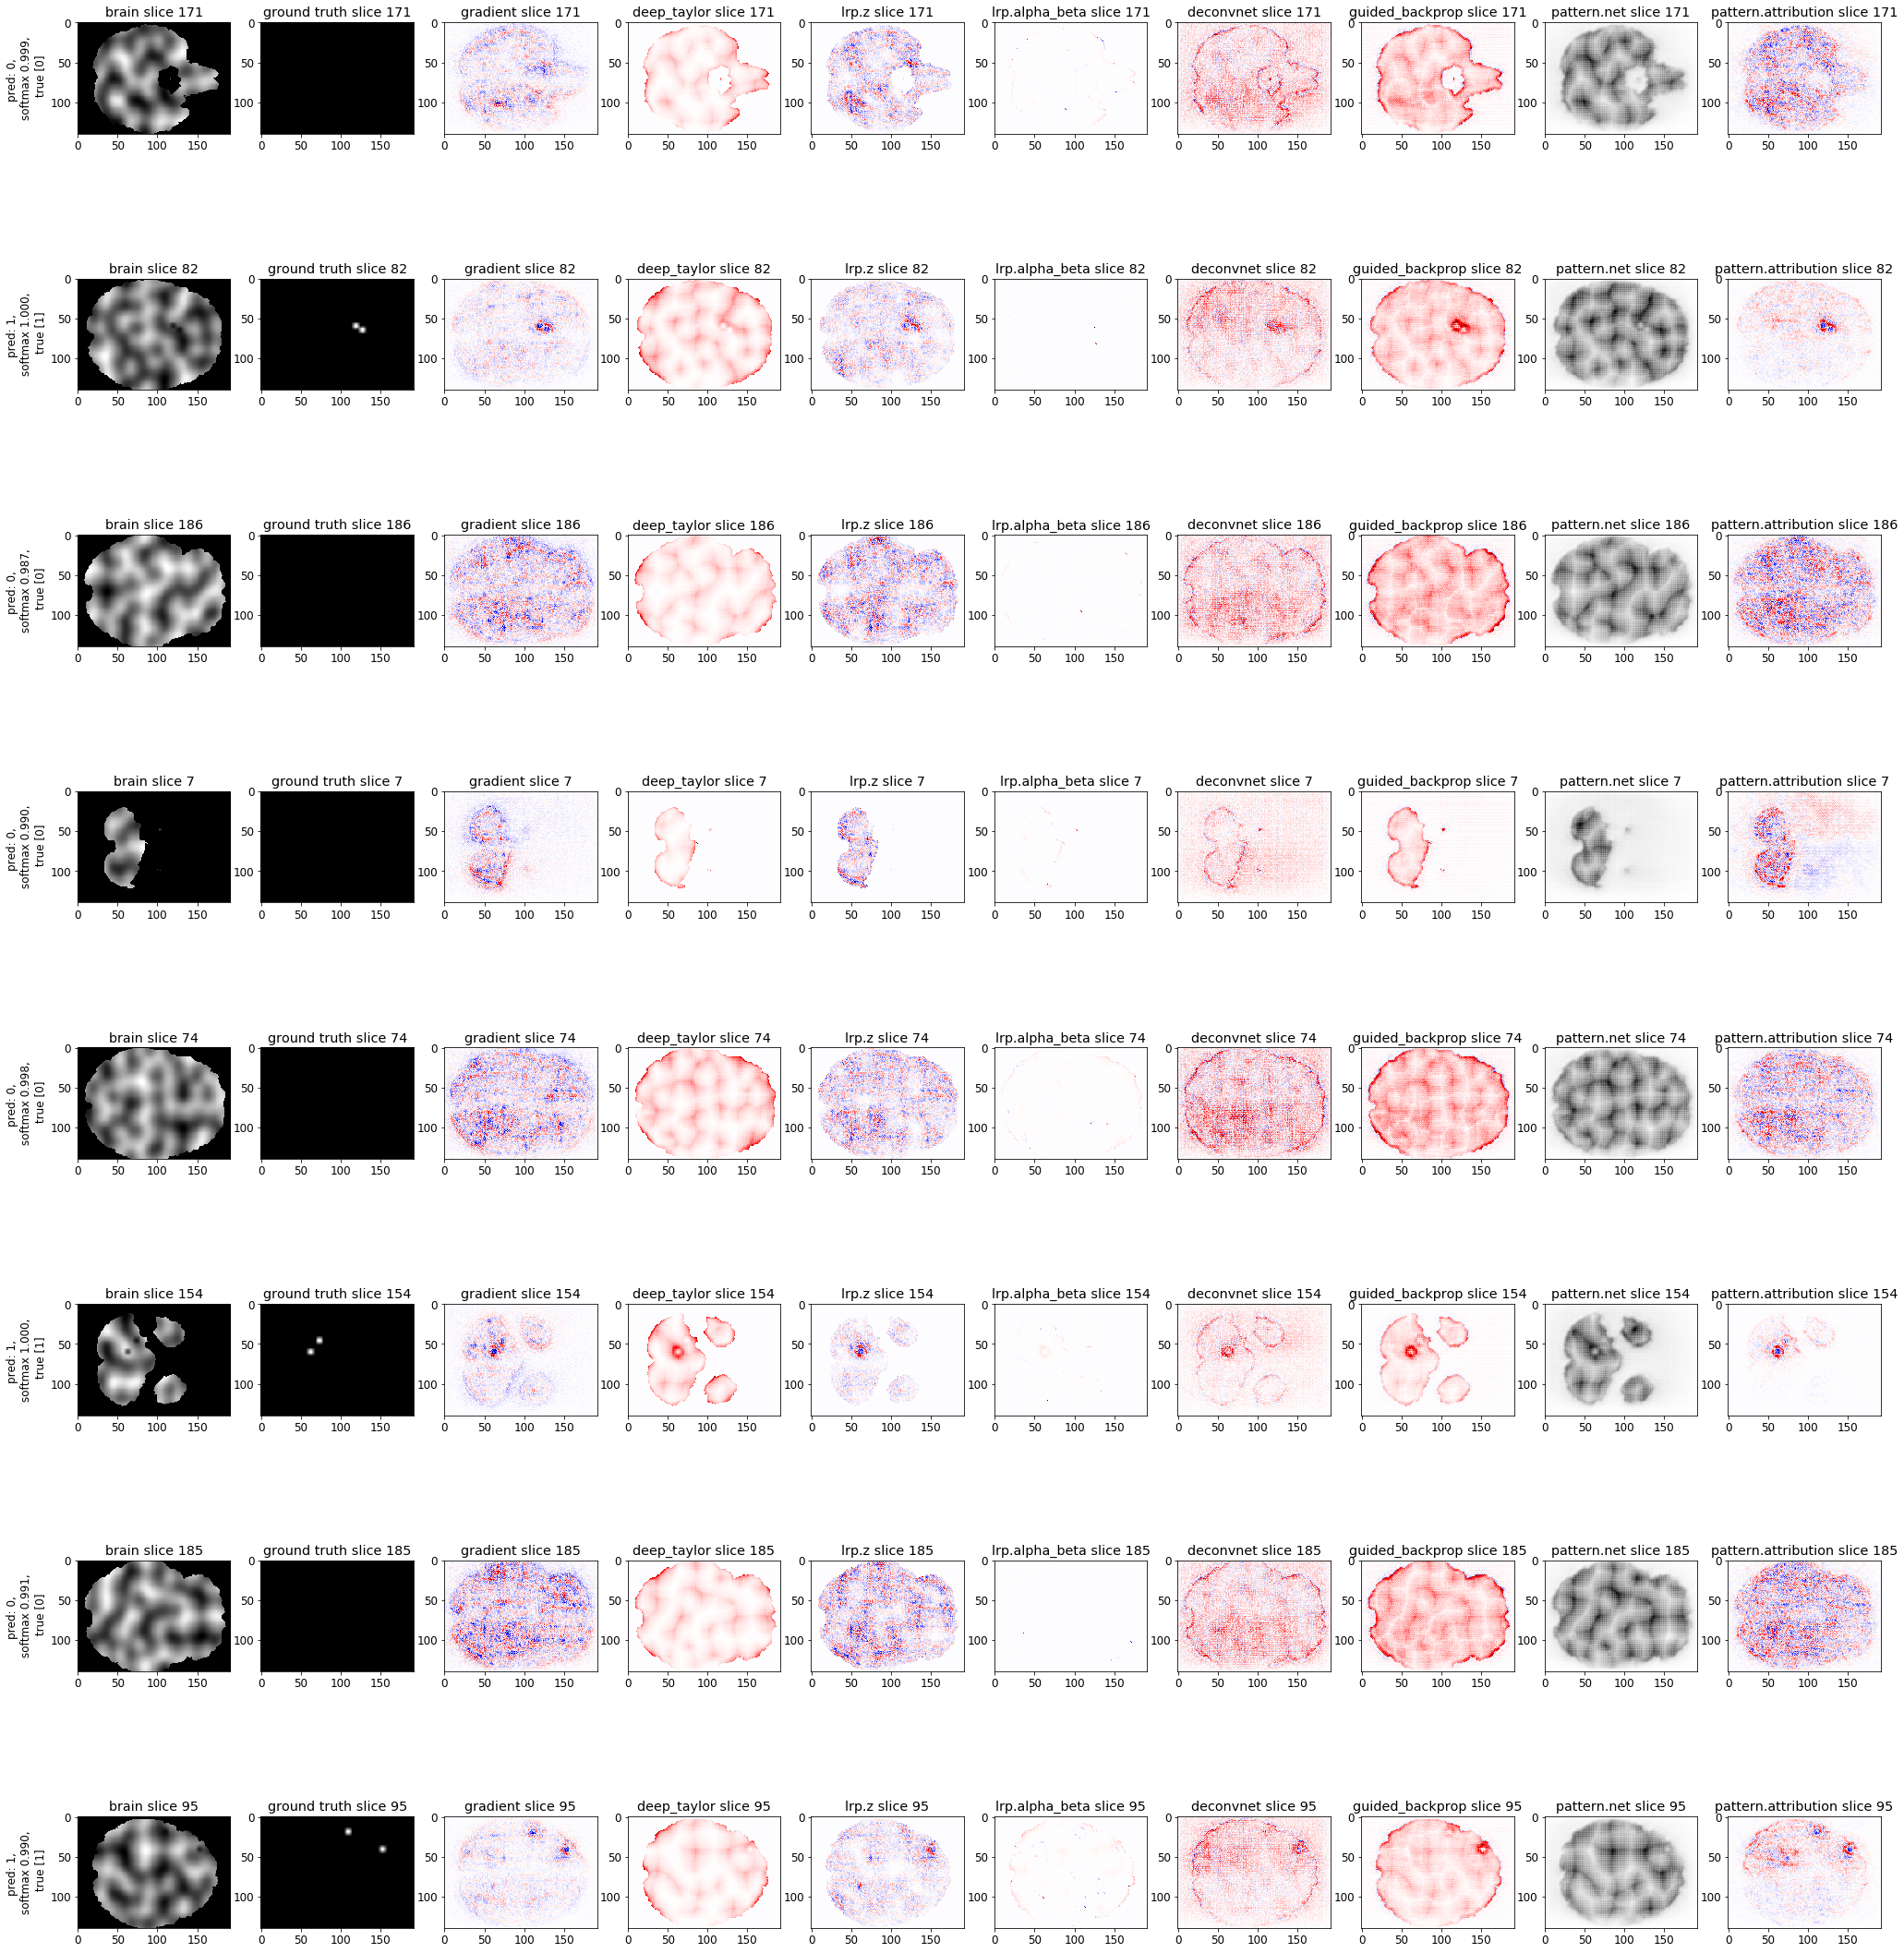

In [26]:
# There is a better way to plot this in the scores notebooks, here just to get a first overview whether the computation worked/
# whether anything weird happened 

fig = plt.figure(figsize = (35, 40))
k = 0
for i, idx in enumerate(list_idx):
    for j in range(len(methods_params) + 2): 
        plt.subplot(8, len(methods_params) + 2, j + k +1)
        label = test_loader[idx][1][[0]]
        if j == 0: 
            brain_img = test_loader[idx][0][[0]]
            img = brain_img.reshape((brain_img.shape[1], brain_img.shape[2]))
            cmap = 'gist_gray'
            title = 'brain'
            
            scores = dict_all_scores['gradient']
            max_score = scores[idx][0].max()
            plt.ylabel(f'pred: {scores[idx][2]}, \n softmax {max_score:.3f}, \n true {label}')
        elif j == 1: 
            img = ground_truth[idx]
            cmap = 'gist_gray'
            title = 'ground truth'
        else:
            method = methods_params[j - 2][0]
            heatmap_list = dict_all_heatmaps[method]
            heatmap = heatmap_list[idx].reshape((heatmap_list[idx].shape[0], heatmap_list[idx].shape[1], heatmap_list[idx].shape[2]))[0]

            if method == 'pattern.net': 
                img = explanation_to_projection(heatmap)
                cmap = 'binary'
            elif method == 'gradient': 
                img = explanation_to_heatmap(np.abs(heatmap))
            else: 
                img = explanation_to_heatmap(heatmap)
            title = method
        plt.imshow(img, cmap = cmap)
        plt.title(f'{title} slice {idx}')
    k += len(methods_params) + 2
    
if save_fig is True: 
    fig.savefig(os.path.join(result_dir, 'figures/overview_heatmaps_scores.png'))

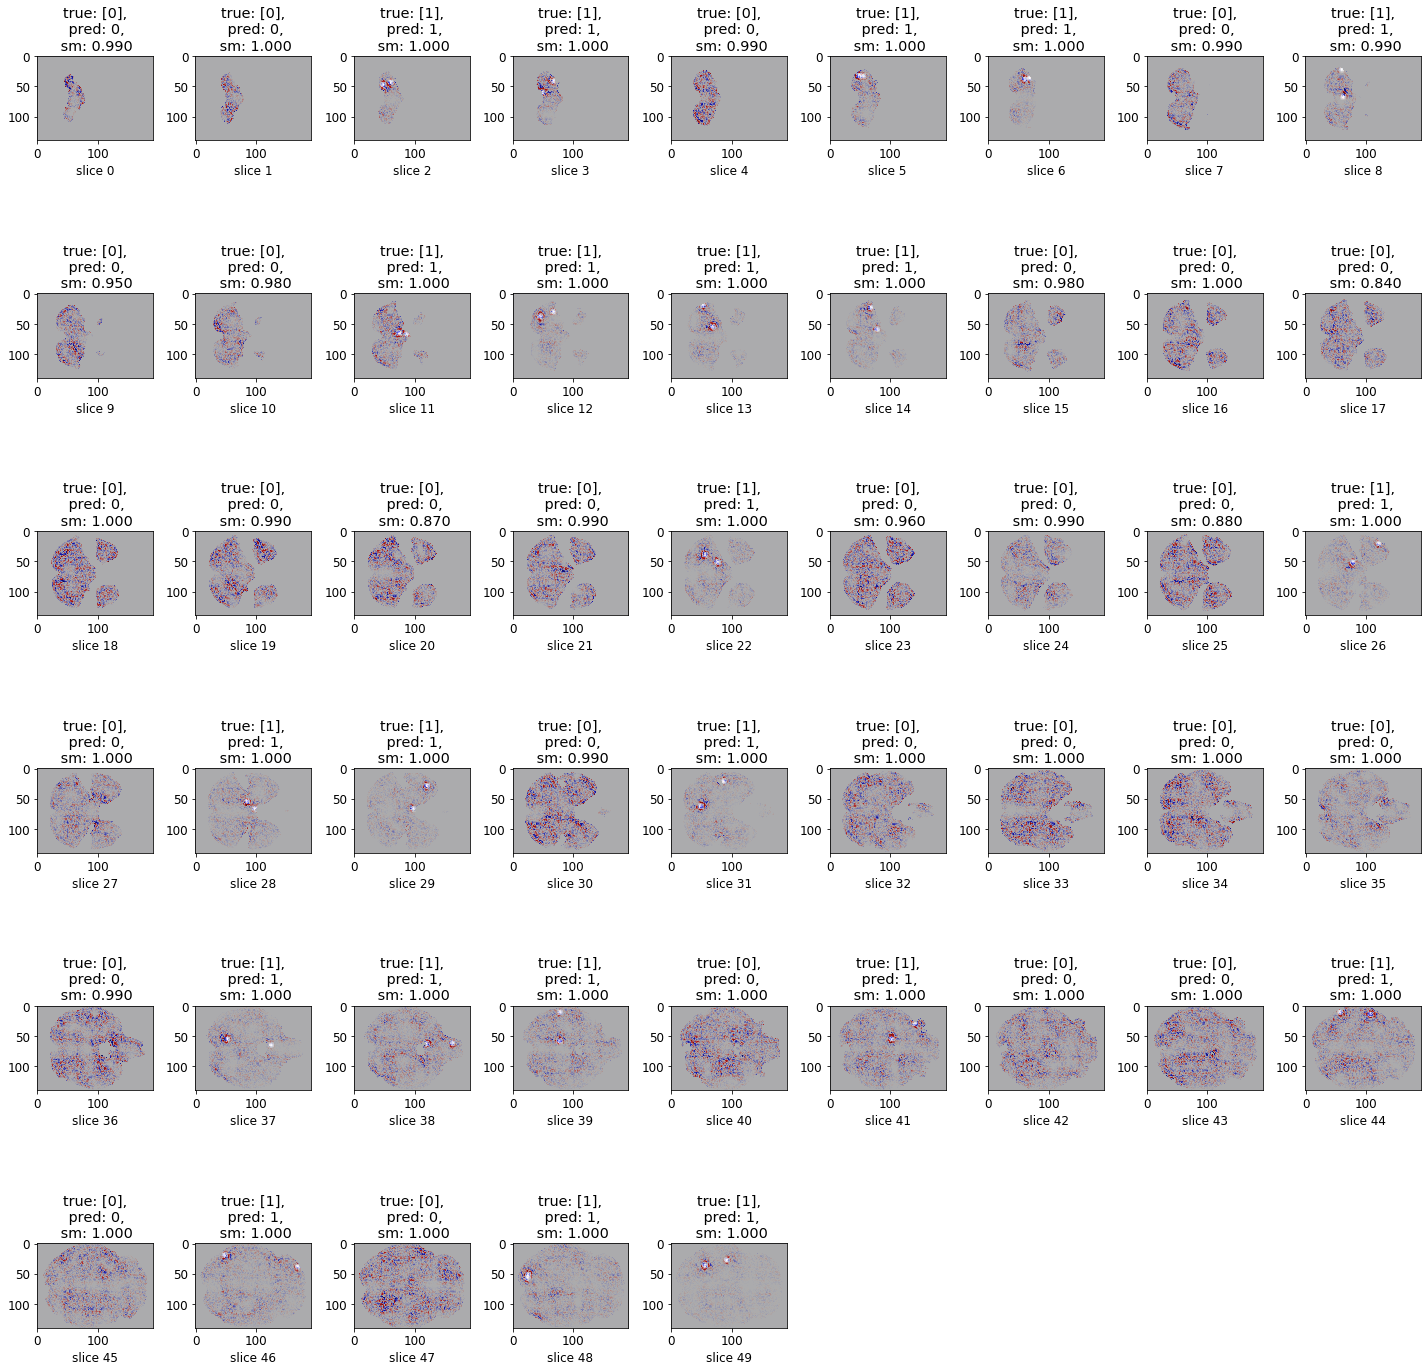

In [27]:
# Note: these figures are not saved, but I used them as a sanity check to 1) check whether the plotted ground truth 
# and heatmap corresponded and 2) as a basic idea for the quality of the heatmap wrt our data 

fig = plt.figure(figsize = (20, 20))
method = 'lrp.z'
for idx in range(50): 
    plt.subplot(6, 9, idx+1)
    scores = dict_all_scores[method]
    heatmap_list = dict_all_heatmaps[method]
    heatmap = heatmap_list[idx].reshape((heatmap_list[idx].shape[0], heatmap_list[idx].shape[1], heatmap_list[idx].shape[2]))[0]
    if method == 'pattern.net':
        img = explanation_to_projection(heatmap)
        cmap = 'binary'
        cmap_ground_truth = 'Reds'
    else: 
        img = explanation_to_heatmap(heatmap)
        cmap = 'seismic'
        cmap_ground_truth = 'gist_gray'

    plt.imshow(ground_truth[idx], cmap = cmap_ground_truth, alpha = 0.8)
    plt.imshow(img, cmap = cmap, alpha = 0.6)
    label = test_loader[idx][1][[0]]
    max_score = np.round(scores[idx][0].max(), 2)
    plt.title(f'true: {label},\n pred: {scores[idx][2]},\n sm: {max_score:.3f}')
    plt.xlabel(f'slice {idx}')
plt.tight_layout()

In [29]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
